In [1]:
#libraries
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
%matplotlib inline
import matplotlib.pyplot as plt
from fancyimpute import IterativeImputer as MICE
from scipy.stats.mstats import winsorize

(CVXPY) Jul 05 07:08:59 PM: Encountered unexpected exception importing solver OSQP:
ImportError('DLL load failed while importing qdldl: The specified module could not be found.')


In [2]:
#assign csv into a datframe
df = pd.read_csv("realtor-data.csv")

In [3]:
df.head()

status  bed  bath  acre_lot        city        state  zip_code  \
0  for_sale  3.0   2.0      0.12    Adjuntas  Puerto Rico     601.0   
1  for_sale  4.0   2.0      0.08    Adjuntas  Puerto Rico     601.0   
2  for_sale  2.0   1.0      0.15  Juana Diaz  Puerto Rico     795.0   
3  for_sale  4.0   2.0      0.10       Ponce  Puerto Rico     731.0   
4  for_sale  6.0   2.0      0.05    Mayaguez  Puerto Rico     680.0   

   house_size prev_sold_date     price  
0       920.0            NaN  105000.0  
1      1527.0            NaN   80000.0  
2       748.0            NaN   67000.0  
3      1800.0            NaN  145000.0  
4         NaN            NaN   65000.0

In [4]:
#a brief look at summary statistics of numerical variables
df.describe()

bed           bath       acre_lot       zip_code  \
count  320108.000000  321618.000000  331873.000000  407693.000000   
mean        3.500200       2.566545      17.418487    3299.396838   
std         2.320135       2.391618     931.723094    2222.641467   
min         1.000000       1.000000       0.000000     601.000000   
25%         2.000000       2.000000       0.200000    1890.000000   
50%         3.000000       2.000000       0.560000    2822.000000   
75%         4.000000       3.000000       2.200000    4630.000000   
max        99.000000     198.000000  100000.000000   99999.000000   

         house_size         price  
count  3.243650e+05  4.078900e+05  
mean   2.222783e+03  6.758307e+05  
std    3.333098e+03  1.178266e+06  
min    1.000000e+02  1.000000e+00  
25%    1.206000e+03  1.999000e+05  
50%    1.767000e+03  3.979000e+05  
75%    2.640000e+03  7.090000e+05  
max    1.450112e+06  6.000000e+07

##### From the summary statistics we can see potential outliers already. For example, houses with 99 beds is highly unlikely and worth investigating. The same goes for a house with 198 bathrooms and a house with 100,000 acres.

In [5]:
df.shape

(407890, 10)

In [6]:
#other variables are turned into categorical variables
#df[["status", "city", "state"]] = df[["status", "city", "state"]].astype("category")
df.dtypes

status             object
bed               float64
bath              float64
acre_lot          float64
city               object
state              object
zip_code          float64
house_size        float64
prev_sold_date     object
price             float64
dtype: object

In [7]:
#date conversion
df['prev_sold_date'] = pd.to_datetime(df['prev_sold_date'], format='%Y-%m-%d')

In [8]:
#counts for each categorical variable to determine posssible data
for column in ["status", "city", "state"]: 
    print(f"Value counts for {column}:")
    print(df[column].value_counts())
    print()

Value counts for status:
status
for_sale          407130
ready_to_build       760
Name: count, dtype: int64

Value counts for city:
city
Boston                31502
San Juan               4788
Providence             4222
Springfield            3987
Worcester              3697
                      ...  
Big Moose Township        1
T3 R12 Wels               1
T13 R8 Wels               1
T11 R4 Wels               1
T6 R1 Nbpp                1
Name: count, Length: 1412, dtype: int64

Value counts for state:
state
Massachusetts     173479
New Hampshire      51394
Vermont            46460
Connecticut        38180
Maine              36650
Rhode Island       28518
Puerto Rico        24679
New York            5829
Virgin Islands      2573
Georgia               48
South Carolina        24
Tennessee             20
Virginia              20
New Jersey            13
Wyoming                3
Name: count, dtype: int64



### Determining missing data presence and Nature

In [9]:
#look for missing data
df.isnull().sum()

status                 0
bed                87782
bath               86272
acre_lot           76017
city                  52
state                  0
zip_code             197
house_size         83525
prev_sold_date    266940
price                  0
dtype: int64

<Axes: >

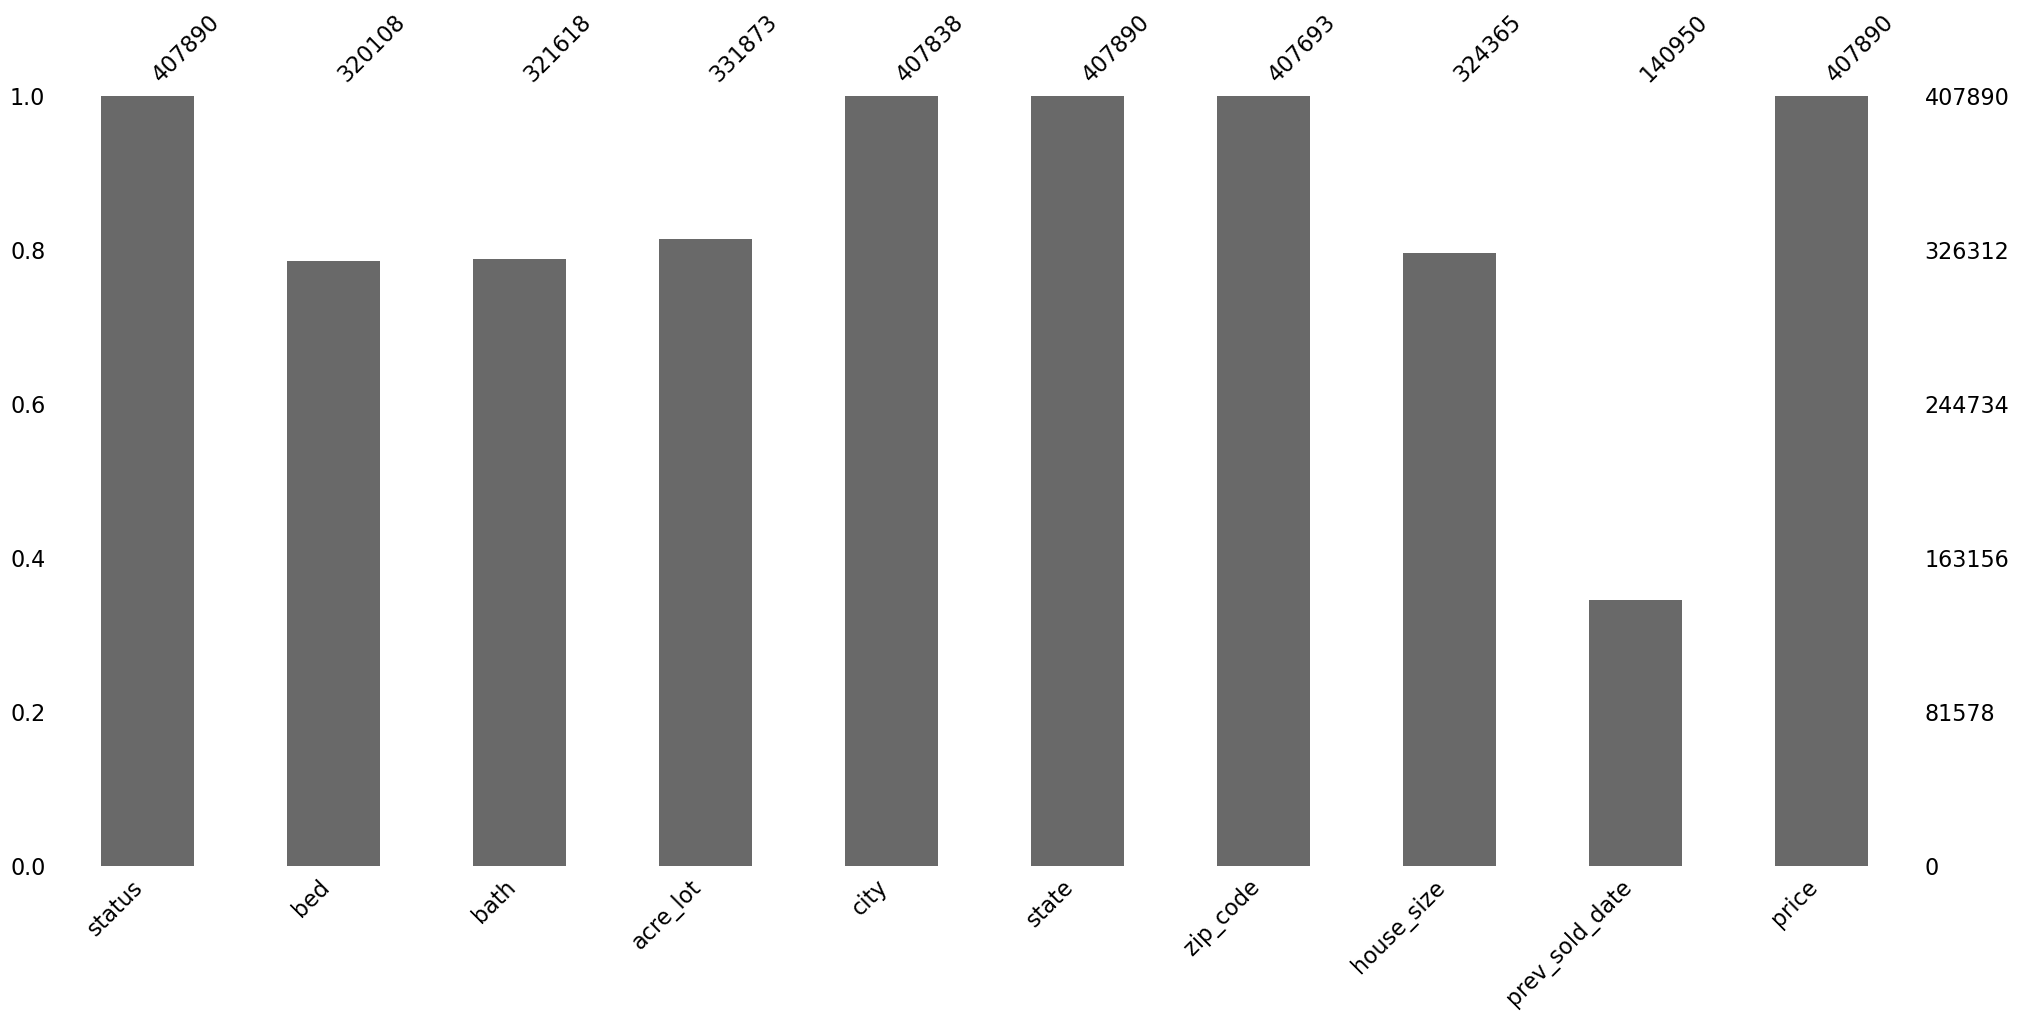

In [10]:
msno.bar(df) 

##### The graph shows that bed, bath, acre_lot and house_size have 20% missing data on average while prev_sold_date has approximately 60% missing. The most likely explanation is that only about 40% of the houses have been sold so far, we can consider the missing data "missing at random (MAR)".

##### In order to determine the nature of missing data of the other mentioned variables, I will do some visualization

<Axes: >

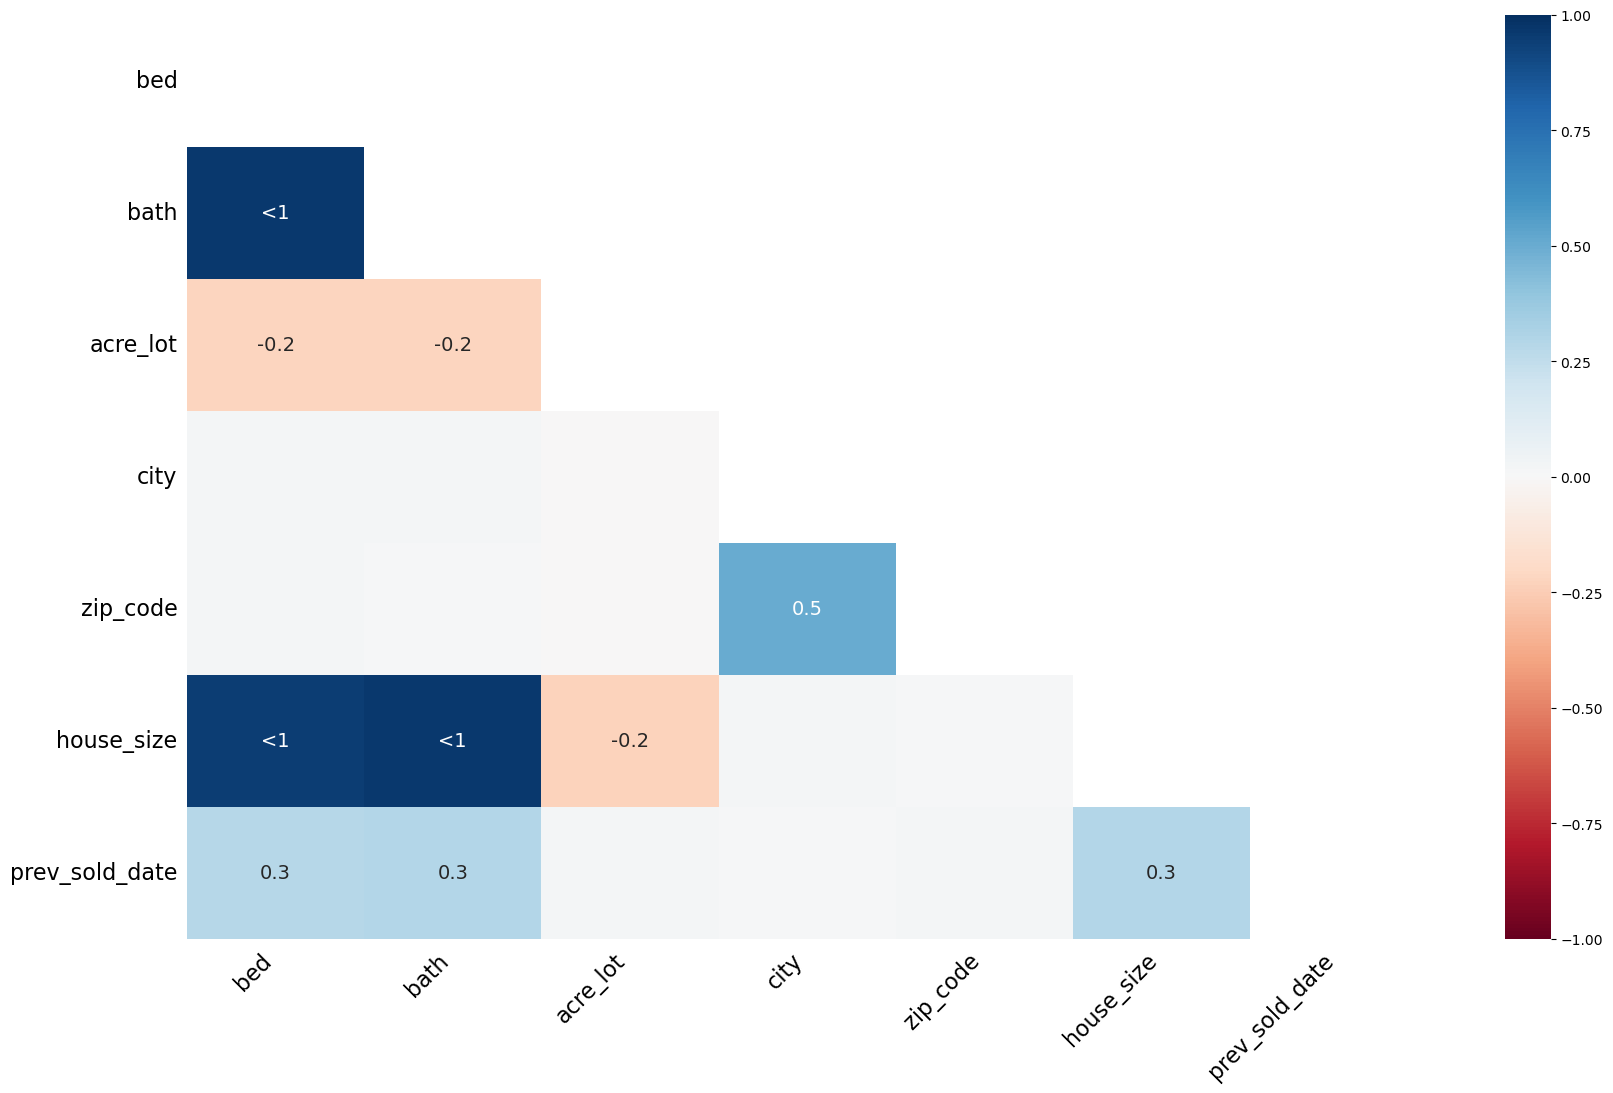

In [11]:
msno.heatmap(df)

##### making a heatmap of the missing variables, we find correlations between the missing data of each variables. According to msno documentation, a value of <1 means that two variables have a correlation close to 1 but not quite. In other words, If bed has data, it is likely bath will have missing data and vice versa. Bed and bath also have <1 when it comes to house size. From this information, we can deduce that the missing data is most likely MAR but because the correlation is close to 1 but not exactly 1, there might be other factors at play which causes the missing data.

##### Logically speaking, house sizes that are smaller could cause it to not have a bedroom or a bathroom and instead, have a singular multi-purpose room. Assuming data is MAR, I will use MICE in order to fill in the missing data. In reference to the correlation matrix, I will not be using "status", "city" and "states" in the imputation as they do not seem to affect variables with missing data in any meaningful way.

In [12]:
#store the dropped columns for later
status = df['status']
prev_sold_date = df['prev_sold_date']
city = df['city']
state = df['state']

#impute the missing data from remaining columns
df_nocat = df.drop(['status','prev_sold_date', 'city', 'state'], axis=1)
df_imputed = MICE().fit_transform(df_nocat)

In [13]:
# Convert the result back to DataFrame
df_imputed = pd.DataFrame(df_imputed, columns = df_nocat.columns)

# Add the dropped columns back to the DataFrame
df_imputed['status'] = status.values
df_imputed['prev_sold_date'] = prev_sold_date.values
df_imputed['city'] = city.values
df_imputed['state'] = state.values

In [14]:
print(df_imputed.isnull().sum())

bed                    0
bath                   0
acre_lot               0
zip_code               0
house_size             0
price                  0
status                 0
prev_sold_date    266940
city                  52
state                  0
dtype: int64


In [15]:
df_imputed.head()

bed  bath  acre_lot  zip_code   house_size     price    status  \
0  3.0   2.0      0.12     601.0   920.000000  105000.0  for_sale   
1  4.0   2.0      0.08     601.0  1527.000000   80000.0  for_sale   
2  2.0   1.0      0.15     795.0   748.000000   67000.0  for_sale   
3  4.0   2.0      0.10     731.0  1800.000000  145000.0  for_sale   
4  6.0   2.0      0.05     680.0  2460.471951   65000.0  for_sale   

  prev_sold_date        city        state  
0            NaT    Adjuntas  Puerto Rico  
1            NaT    Adjuntas  Puerto Rico  
2            NaT  Juana Diaz  Puerto Rico  
3            NaT       Ponce  Puerto Rico  
4            NaT    Mayaguez  Puerto Rico

### Check For Outliers

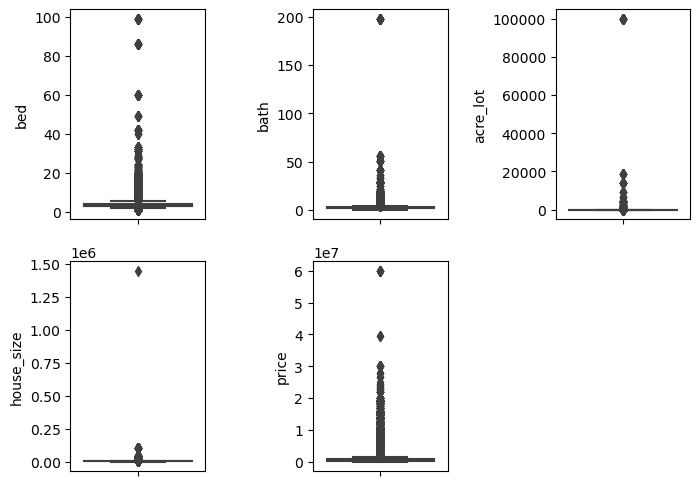

In [16]:
#boxplots of numerical variables
plt.figure(figsize=(8, 6))

plt.subplot(2, 3, 1)
sns.boxplot(y=df_imputed['bed'])

plt.subplot(2, 3, 2)
sns.boxplot(y=df_imputed['bath'])

plt.subplot(2, 3, 3)
sns.boxplot(y=df_imputed['acre_lot'])

plt.subplot(2, 3, 4)
sns.boxplot(y=df_imputed['house_size'])

plt.subplot(2, 3, 5)
sns.boxplot(y=df_imputed['price'])

plt.subplots_adjust(wspace=0.8) 
plt.show()

##### Confirming my initial observation from summary statistics, we can see that bed, bath, acre_lot, house_size and price have outliers.

In [17]:
#check for houses with over 90 bedrooms
df_imputed[df_imputed['bed'] > 90].head()

bed   bath  acre_lot  zip_code  house_size      price    status  \
121247  99.0  198.0      0.29    2152.0     14462.0  5300000.0  for_sale   
121571  99.0  198.0      0.29    2152.0     14462.0  5300000.0  for_sale   
125572  99.0  198.0      0.29    2152.0     14462.0  5300000.0  for_sale   
128105  99.0  198.0      0.29    2152.0     14462.0  5300000.0  for_sale   
134625  99.0  198.0      0.29    2152.0     14462.0  5300000.0  for_sale   

       prev_sold_date      city          state  
121247            NaT  Winthrop  Massachusetts  
121571            NaT  Winthrop  Massachusetts  
125572            NaT  Winthrop  Massachusetts  
128105            NaT  Winthrop  Massachusetts  
134625            NaT  Winthrop  Massachusetts

##### Through some brief research, I have found the biggest property in USA to be the Biltmore Estate which has; 43 bathrooms, 34 bedrooms, 65 fireplaces, 8000 acres of land and 178,926 sq ft of area. Based on this information, I can deduce the upper limit on certain variables and determine which are outliers. To address them, I will winsorize the variables bed, bathroom, acre_lot and house_size.

In [18]:
# apply winsorizing to each column
columns = ['bed', 'bath', 'acre_lot', 'house_size','price']
for col in columns:
    df_imputed[col] = winsorize(df_imputed[col], limits=[0.01, 0.01])

In [19]:
df_imputed.describe()

C:\Users\Pumpernickel\anaconda3\lib\site-packages\numpy\lib\function_base.py:4823: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\Pumpernickel\anaconda3\lib\site-packages\numpy\lib\function_base.py:4823: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\Pumpernickel\anaconda3\lib\site-packages\numpy\lib\function_base.py:4823: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\Pumpernickel\anaconda3\lib\site-packages\numpy\lib\function_base.py:4823: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\Pumpernickel\anaconda3\lib\site-packages\numpy\lib\function_base.py:4823: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\Pumpernickel\anaconda3\lib\site-packages\numpy\lib\function_base.py:4823: UserWarning: Warning: 'partition

bed           bath       acre_lot       zip_code  \
count  407890.000000  407890.000000  407890.000000  407890.000000   
mean        3.425682       2.481496       6.525648    3299.435034   
min         1.000000       1.000000      -5.890106     601.000000   
25%         3.000000       2.000000       0.220000    1890.000000   
50%         3.000000       2.236030       0.920000    2825.000000   
75%         4.000000       3.000000       5.060000    4628.000000   
max        10.000000       8.000000     113.100000   99999.000000   
std         1.503739       1.222766      16.362308    2222.105655   

          house_size         price                 prev_sold_date  
count  407890.000000  4.078900e+05                         140950  
mean     2120.592148  6.390089e+05  2007-11-04 21:01:29.342319872  
min       535.000000  2.490000e+04            1901-01-01 00:00:00  
25%      1340.416012  1.999000e+05            2001-11-05 00:00:00  
50%      1848.000000  3.979000e+05            2007-09-04 00:00:00  
75%      2417.000000  7.090000e+05            2017-01-16 00:00:00  
max      8196.000000  5.450000e+06            2022-12-01 00:00:00  
std      1280.619330  8.370572e+05                            NaN

##### After winsorizing our numeric variables, we are able to replace potential outliers with values at the 1%. Even these values are less than the above mentioned property but for the purposes of this analysis, it is sufficient.

### Visualizing distributions

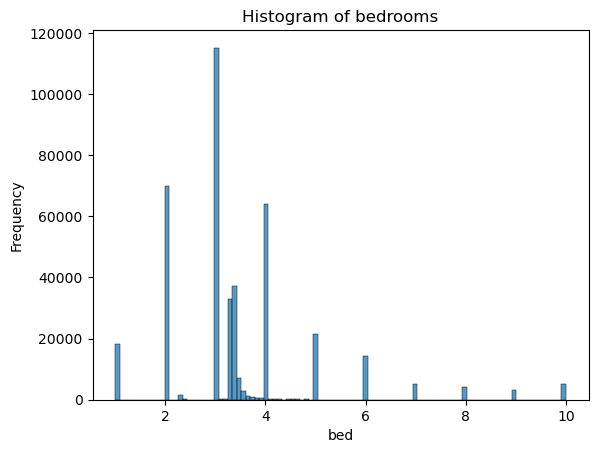

In [20]:
#Bedrooms
sns.histplot(df_imputed['bed'], bins = 100)  # Increase the number of bins
plt.xlabel('bed')
plt.ylabel('Frequency')
plt.title('Histogram of bedrooms')
plt.show()

##### Here we can see the imputed values of the missing data of 'bed'. As most houses have intergers for bed, those that were previously missing now have decimal values that lie between 2 and 5 bedrooms.

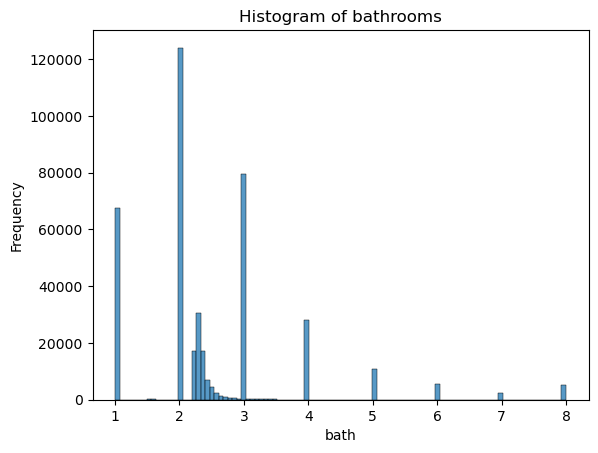

In [21]:
#Bathrooms
sns.histplot(df_imputed['bath'], bins = 100)
plt.xlabel('bath')
plt.ylabel('Frequency')
plt.title('Histogram of bathrooms')
plt.show()

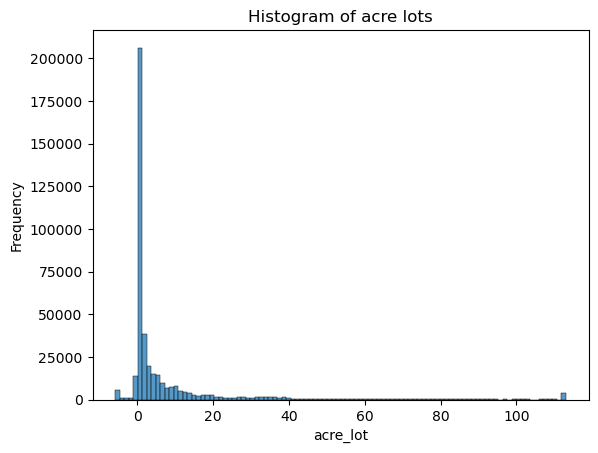

In [22]:
#Acre lots
sns.histplot(df_imputed['acre_lot'], bins = 100)
plt.xlabel('acre_lot')
plt.ylabel('Frequency')
plt.title('Histogram of acre lots')
plt.show()

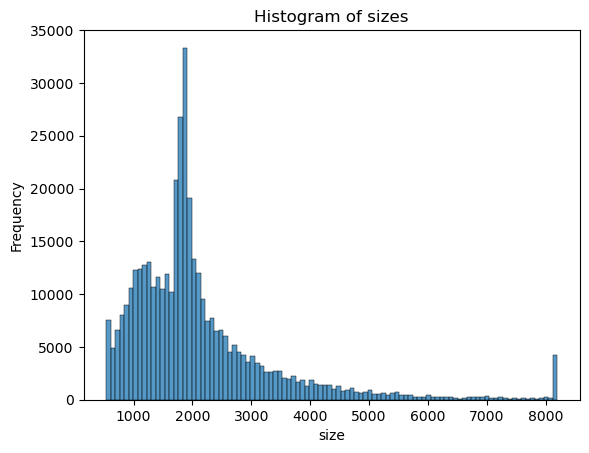

In [23]:
#House Size
sns.histplot(df_imputed['house_size'], bins = 100)
plt.xlabel('size')
plt.ylabel('Frequency')
plt.title('Histogram of sizes')
plt.show()

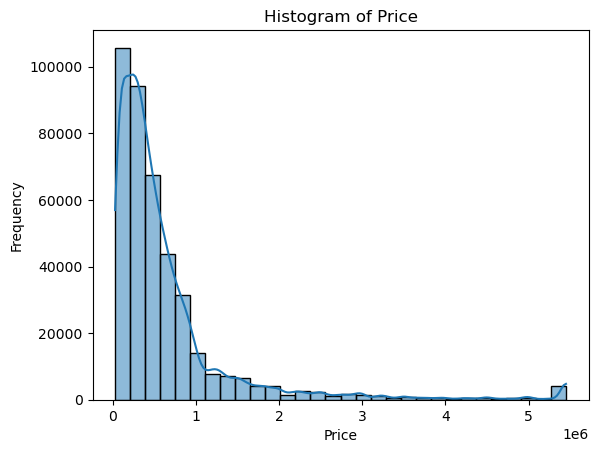

In [24]:
#Histogram of price
sns.histplot(df_imputed['price'], bins=30,kde=True)  # Increase the number of bins
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Histogram of Price')
plt.show()

In [25]:
#make heat map that measures price in different states

In [26]:
#Data imported from https://simplemaps.com/data/us-zips
uszips = pd.read_csv('uszips.csv')

In [34]:
uszips.rename(columns={'zip': 'zip_code'}, inplace=True)
uszips['zip_code'] = uszips['zip_code'].astype('float')
uszips.head()

zip_code       lat       lng       city state_id   state_name  zcta  \
0     601.0  18.18027 -66.75266   Adjuntas       PR  Puerto Rico  True   
1     602.0  18.36075 -67.17541     Aguada       PR  Puerto Rico  True   
2     603.0  18.45744 -67.12225  Aguadilla       PR  Puerto Rico  True   
3     606.0  18.16585 -66.93716    Maricao       PR  Puerto Rico  True   
4     610.0  18.29110 -67.12243     Anasco       PR  Puerto Rico  True   

   parent_zcta  population  density  county_fips county_name  \
0          NaN     17126.0    102.6        72001    Adjuntas   
1          NaN     37895.0    482.5        72003      Aguada   
2          NaN     49136.0    552.4        72005   Aguadilla   
3          NaN      5751.0     50.1        72093     Maricao   
4          NaN     26153.0    272.1        72011      Añasco   

                                      county_weights  \
0                    {"72001": 98.73, "72141": 1.27}   
1                                     {"72003": 100}   
2                    {"72005": 99.76, "72099": 0.24}   
3    {"72093": 82.26, "72153": 11.68, "72121": 6.06}   
4  {"72011": 96.71, "72099": 2.81, "72083": 0.37,...   

                county_names_all          county_fips_all  imprecise  \
0                Adjuntas|Utuado              72001|72141      False   
1                         Aguada                    72003      False   
2                 Aguadilla|Moca              72005|72099      False   
3    Maricao|Yauco|Sabana Grande        72093|72153|72121      False   
4  Añasco|Moca|Las Marías|Aguada  72011|72099|72083|72003      False   

   military             timezone  
0     False  America/Puerto_Rico  
1     False  America/Puerto_Rico  
2     False  America/Puerto_Rico  
3     False  America/Puerto_Rico  
4     False  America/Puerto_Rico

In [37]:
dfzips = df_imputed.merge(uszips, left_on='zip_code', right_on='zip_code', suffixes=('_df', '_uszips'))

bed  bath  acre_lot  zip_code  house_size     price    status  \
0  3.0   2.0      0.12     601.0       920.0  105000.0  for_sale   
1  4.0   2.0      0.08     601.0      1527.0   80000.0  for_sale   
2  3.0   2.0      0.12     601.0       920.0  105000.0  for_sale   
3  4.0   2.0      0.08     601.0      1527.0   80000.0  for_sale   
4  3.0   2.0      0.12     601.0       920.0  105000.0  for_sale   

  prev_sold_date   city_df        state  ...  population  density county_fips  \
0            NaT  Adjuntas  Puerto Rico  ...     17126.0    102.6       72001   
1            NaT  Adjuntas  Puerto Rico  ...     17126.0    102.6       72001   
2            NaT  Adjuntas  Puerto Rico  ...     17126.0    102.6       72001   
3            NaT  Adjuntas  Puerto Rico  ...     17126.0    102.6       72001   
4            NaT  Adjuntas  Puerto Rico  ...     17126.0    102.6       72001   

  county_name                   county_weights  county_names_all  \
0    Adjuntas  {"72001": 98.73, "72141": 1.27}   Adjuntas|Utuado   
1    Adjuntas  {"72001": 98.73, "72141": 1.27}   Adjuntas|Utuado   
2    Adjuntas  {"72001": 98.73, "72141": 1.27}   Adjuntas|Utuado   
3    Adjuntas  {"72001": 98.73, "72141": 1.27}   Adjuntas|Utuado   
4    Adjuntas  {"72001": 98.73, "72141": 1.27}   Adjuntas|Utuado   

   county_fips_all  imprecise  military             timezone  
0      72001|72141      False     False  America/Puerto_Rico  
1      72001|72141      False     False  America/Puerto_Rico  
2      72001|72141      False     False  America/Puerto_Rico  
3      72001|72141      False     False  America/Puerto_Rico  
4      72001|72141      False     False  America/Puerto_Rico  

[5 rows x 27 columns]

In [39]:
coord_df = dfzips[['zip_code', 'price', 'prev_sold_date', 'city_df', 'lat', 'lng']]
coord_df.head()

zip_code     price prev_sold_date   city_df       lat       lng
0     601.0  105000.0            NaT  Adjuntas  18.18027 -66.75266
1     601.0   80000.0            NaT  Adjuntas  18.18027 -66.75266
2     601.0  105000.0            NaT  Adjuntas  18.18027 -66.75266
3     601.0   80000.0            NaT  Adjuntas  18.18027 -66.75266
4     601.0  105000.0            NaT  Adjuntas  18.18027 -66.75266